# <center> Прототип решения по Треку 3:</center> <center> «Предсказание вероятности возникновения ДТП»</center>

## Постановка задачи

Разработать алгоритм прогнозирующий наиболее вероятную категорию события дорожно-транспортного происшествия (далее по тексту «ДТП»):

>1. ДТП не произойдет
>1. ДТП произойдет без пострадавших
>1. ДТП произойдет с пострадавшими

Данные для обучения — информация о ДТП от ГИБДД и ВНИИ ГОЧС, а также дополнительные данные по интенсивности движения, метеоусловиях на участках дороги и др. В качестве федеральных автомобильных дорог рассматриваются М-8 «Холмогоры» и Р-21 «Кола».

## Прототип решения

In [3]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn import svm
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import re
import functools
from geopy.distance import geodesic
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import numpy as np
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder

In [4]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [5]:
def remove_zero(df):
    return (df[(~df['target'].isnull()) & (df['target']!=0)])

def hour_rounder(t):
    return (t.replace(second=0, microsecond=0, minute=0, hour=t.hour)
               +timedelta(hours=t.minute//30))

Подготовка датасета train и test

In [6]:
#df для подсчета статистик
df = pd.read_csv('data/train.csv', usecols=[0, 1, 2, 3, 4, 5, 7,8, 10], parse_dates=['datetime'])
df = df.sort_values('datetime', ascending=True)
df.reset_index(drop=True, inplace=True)
df.head(2)

,datetime,road_id,road_km,man_injured_num,man_dead_num,car_damaged_num,lon,lat,target
0,2012-01-01 12:00:00,14,1276,1,0,1.0,33.319,68.212,2
1,2012-01-01 22:00:00,9,278,2,0,3.0,0.000,0.000,2


In [7]:
# исключение из выборки ЧС и определение временного интервала
condition1 = (df["target"]!=3)
condition2 = (df['datetime'] > '2015-01-01')
condition3 = (df['datetime'] < '2020-12-31')
road_train = df[(condition1 & condition2 & condition3)]
road_train = road_train[['datetime', 'road_id', 'road_km', 'target']]
road_train.head(2)

,datetime,road_id,road_km,target
5990,2015-01-01 05:00:00,9,22,1
5991,2015-01-01 06:00:00,9,22,1


In [8]:
road_test = pd.read_csv('data/test.csv', parse_dates=['datetime'])
road_test.head(2)

,datetime,road_id,road_km,target
0,2020-01-01 01:00:00,9,0,NaN
1,2020-01-01 01:00:00,9,1,NaN


Информация о трейне и тесте

In [9]:
df.target.value_counts()

1    89112
2    23166
3       39
Name: target, dtype: int64

In [21]:
df.road_id.value_counts()

5     61126
9     34570
14    16621
Name: road_id, dtype: int64

In [10]:
road_test.shape

(1729451, 4)

## Добавление данных о трафике

Для дальнейшего обучения модели **выберем данные о ДТП по трем трассам**. Рассмотрим ситуацию для значений переменной `target` 1 и 2, исключив ЧС. Выберем период наблюдения с 2019-01-01 по 2020-12-31, заполним промежутки между наблюдениями на всем временном интервале нулевыми значениями с шагом в один час, присвоив значения 0 (событие не является ДТП) переменной `target`, и обогатим исходную выборку переменными из других датасетов.

In [11]:
traffic = pd.read_csv('data/traffic.csv', usecols=[0, 1, 2, 7, 9, 10, 11], parse_dates=['datetime'])
traffic['datetime'] = traffic['datetime'] + pd.Timedelta(seconds=1) #чтобы мержилось
data = traffic.groupby(['datetime', 'road_id', 'road_km']).agg({'lane_count':'max', 'volume':'sum', 'occupancy':'mean', 'speed':'mean'}).reset_index()
data.head(2)

,datetime,road_id,road_km,lane_count,volume,occupancy,speed
0,2016-01-01 01:00:00,9,181,1,74.0,1.0000,67.915
1,2016-01-01 01:00:00,9,274,2,548.0,2.3075,83.175


In [14]:
# объединение датасета с данными о ДТП с данными о трафике
train = pd.merge(road_train, data, how='outer', on=['datetime', 'road_id', 'road_km'])
condition1 = (train['target'].isnull()) & (train['volume'].isnull())
condition2 = ~(train['target'].isnull()) & (train['volume'].isnull())
train = train.drop(train[condition1].index)
train = train.drop(train[condition2].index)
train = train.fillna(0)
train['year'] = [d.year for d in train['datetime']]
train['week'] = train['datetime'].dt.isocalendar().week
train['week'] = train['week'].astype("int8")
train['dayofweek'] = [d.dayofweek for d in train['datetime']]
train['hour'] = [d.hour for d in train['datetime']]
train.head(2)

,datetime,road_id,road_km,target,lane_count,volume,occupancy,speed,year,week,dayofweek,hour
16992,2016-01-05 09:00:00,9,790,2.0,1.0,588.0,3.8750,80.60,2016,1,1,9
17127,2016-01-06 14:00:00,9,1151,1.0,2.0,1508.0,6.2525,57.25,2016,1,2,14


In [15]:
test = pd.merge(road_test, data, how='outer', on=['datetime', 'road_id', 'road_km'])
condition1 = (test['target'].isnull()) & (test['volume'].isnull())
test = test.drop(test[condition1].index)
test['year'] = [d.year for d in test['datetime']]
test['week'] = test['datetime'].dt.isocalendar().week
test['week'] = test['week'].astype("int8")
test['dayofweek'] = [d.dayofweek for d in test['datetime']]
test['hour'] = [d.hour for d in test['datetime']]
test.head(2)

,datetime,road_id,road_km,target,lane_count,volume,occupancy,speed,year,week,dayofweek,hour
38,2020-01-01 01:00:00,9,38,NaN,3.0,657.0,4.166667,92.048594,2020,1,2,1
57,2020-01-01 01:00:00,9,57,NaN,3.0,1073.0,3.348884,74.404866,2020,1,2,1


### Добавление статистик

In [16]:
#аварийность участка
history = df.groupby(['road_id', 'road_km']).agg({'man_injured_num':'sum', 'man_dead_num':'sum', 'car_damaged_num':'sum', 'datetime':'count', 'target':'mean'}).reset_index()
history.rename(columns={'man_injured_num': 'man_injured_h', 'man_dead_num': 'man_dead_h','car_damaged_num': 'car_damaged_h','datetime': 'count_h','target': 'target_h',}, inplace=True)
history.head(2)

,road_id,road_km,man_injured_h,man_dead_h,car_damaged_h,count_h,target_h
0,5,0,320,29,451.0,262,1.80916
1,5,1,7,0,42.0,25,1.16000


In [17]:
train = pd.merge(train, history, how='left', on=['road_id', 'road_km'])
test = pd.merge(test, history, how='left', on=['road_id', 'road_km'])
test.head(2)

,datetime,road_id,road_km,target,lane_count,volume,occupancy,speed,year,week,dayofweek,hour,man_injured_h,man_dead_h,car_damaged_h,count_h,target_h
0,2020-01-01 01:00:00,9,38,NaN,3.0,657.0,4.166667,92.048594,2020,1,2,1,22,1,365.0,202,1.099010
1,2020-01-01 01:00:00,9,57,NaN,3.0,1073.0,3.348884,74.404866,2020,1,2,1,19,2,191.0,113,1.097345


В среднем по временным интервалам

In [18]:
#df['year'] = [d.year for d in df['datetime']]
#df['month'] = [d.month for d in df['datetime']]
#df['day'] = [d.day for d in df['datetime']]
df['week'] = df['datetime'].dt.isocalendar().week
df['week'] = df['week'].astype("int8")
df['dayofweek'] = [d.dayofweek for d in df['datetime']]
df['hour'] = [d.hour for d in df['datetime']]

In [19]:
dtp_week = df.groupby(['road_id', 'road_km', 'week']).agg({'datetime':'count', 'target':'mean'}).reset_index()
dtp_week.rename(columns={'datetime': 'count_week','target': 'target_week',}, inplace=True)
dtp_week.head(2)

,road_id,road_km,week,count_week,target_week
0,5,0,1,4,2.000000
1,5,0,2,3,1.333333


In [20]:
dtp_dayofweek = df.groupby(['road_id', 'road_km', 'dayofweek']).agg({'datetime':'count', 'target':'mean'}).reset_index()
dtp_dayofweek.rename(columns={'datetime': 'count_dayofweek','target': 'target_dayofweek',}, inplace=True)
dtp_dayofweek.head(2)

,road_id,road_km,dayofweek,count_dayofweek,target_dayofweek
0,5,0,0,31,1.677419
1,5,0,1,29,1.896552


In [21]:
dtp_hour = df.groupby(['road_id', 'road_km', 'hour']).agg({'datetime':'count', 'target':'mean'}).reset_index()
dtp_hour.rename(columns={'datetime': 'count_hour','target': 'target_hour',}, inplace=True)
dtp_hour.head(2)

,road_id,road_km,hour,count_hour,target_hour
0,5,0,0,16,1.8125
1,5,0,1,4,2.0000


In [22]:
train = pd.merge(train, dtp_week, how='left', on=['road_id', 'road_km', 'week'])
train = pd.merge(train, dtp_dayofweek, how='left', on=['road_id', 'road_km', 'dayofweek'])
train = pd.merge(train, dtp_hour, how='left', on=['road_id', 'road_km', 'hour'])
train.head(2)

,datetime,road_id,road_km,target,lane_count,volume,occupancy,speed,year,week,dayofweek,hour,man_injured_h,man_dead_h,car_damaged_h,count_h,target_h,count_week,target_week,count_dayofweek,target_dayofweek,count_hour,target_hour
0,2016-01-05 09:00:00,9,790,2.0,1.0,588.0,3.8750,80.60,2016,1,1,9,4,0,34.0,18,1.111111,1.0,2.0,6.0,1.333333,3.0,1.333333
1,2016-01-06 14:00:00,9,1151,1.0,2.0,1508.0,6.2525,57.25,2016,1,2,14,6,0,39.0,22,1.136364,1.0,1.0,4.0,1.250000,2.0,1.000000


In [23]:
test = pd.merge(test, dtp_week, how='left', on=['road_id', 'road_km', 'week'])
test = pd.merge(test, dtp_dayofweek, how='left', on=['road_id', 'road_km', 'dayofweek'])
test = pd.merge(test, dtp_hour, how='left', on=['road_id', 'road_km', 'hour'])
test.head(2)

,datetime,road_id,road_km,target,lane_count,volume,occupancy,speed,year,week,dayofweek,hour,man_injured_h,man_dead_h,car_damaged_h,count_h,target_h,count_week,target_week,count_dayofweek,target_dayofweek,count_hour,target_hour
0,2020-01-01 01:00:00,9,38,NaN,3.0,657.0,4.166667,92.048594,2020,1,2,1,22,1,365.0,202,1.099010,1.0,1.0,29.0,1.103448,2.0,1.0
1,2020-01-01 01:00:00,9,57,NaN,3.0,1073.0,3.348884,74.404866,2020,1,2,1,19,2,191.0,113,1.097345,2.0,1.0,16.0,1.312500,3.0,1.0


Дорога М-4 (5) не используется

## Аварийность и ремонт

In [24]:
repair = pd.read_csv('data/repair.csv', parse_dates=['datetime'])[['datetime', 'road_id', 'road_km', 'length']]
repair['year'] = [d.year for d in repair['datetime']]
repair.head(2)

,datetime,road_id,road_km,length,year
0,2015-01-01,9,848,48.48,2015
1,2015-01-01,9,57,0.00,2015


In [25]:
crash_col = ['datetime', 'road_id', 'road_km', 'avuch_loc', 'stabchar_type', 'length']
crash_parts = pd.read_csv('data/crash_parts.csv', parse_dates=['datetime'], index_col=0)[crash_col]
crash_parts.rename(columns={'length': 'crash_length',}, inplace=True)
crash_parts['year'] = [d.year for d in crash_parts['datetime']]
crash_parts.head(2)

,datetime,road_id,road_km,avuch_loc,stabchar_type,crash_length,year
0,2017-01-01,9,124,2,3,970,2017
1,2017-01-01,9,125,2,3,970,2017


In [28]:
train = pd.merge(train, repair[['year', 'road_id', 'road_km', 'length']], how='left', on=['road_id', 'road_km', 'year'])
train = pd.merge(train, crash_parts[['road_id', 'road_km', 'avuch_loc', 'stabchar_type', 'crash_length', 'year']], how='left', on=['road_id', 'road_km', 'year'])
train.head(2)

,datetime,road_id,road_km,target,lane_count,volume,occupancy,speed,year,week,dayofweek,hour,man_injured_h,man_dead_h,car_damaged_h,count_h,target_h,count_week,target_week,count_dayofweek,target_dayofweek,count_hour,target_hour,length,avuch_loc,stabchar_type,crash_length
0,2016-01-05 09:00:00,9,790,2.0,1.0,588.0,3.8750,80.60,2016,1,1,9,4,0,34.0,18,1.111111,1.0,2.0,6.0,1.333333,3.0,1.333333,NaN,NaN,NaN,NaN
1,2016-01-06 14:00:00,9,1151,1.0,2.0,1508.0,6.2525,57.25,2016,1,2,14,6,0,39.0,22,1.136364,1.0,1.0,4.0,1.250000,2.0,1.000000,NaN,NaN,NaN,NaN


In [27]:
test = pd.merge(test, repair[['year', 'road_id', 'road_km', 'length']], how='left', on=['road_id', 'road_km', 'year'])
test = pd.merge(test, crash_parts[['road_id', 'road_km', 'avuch_loc', 'stabchar_type', 'crash_length', 'year']], how='left', on=['road_id', 'road_km', 'year'])

### Метеостанции

In [29]:
#файл сохраненный из match_station.ipynb
km_coord = pd.read_csv('data/km_coord.csv')
km_coord.head(2)

,road_id,road_km,lat_long,station
0,9,0,"(55.76, 37.61)",MOSKMIH
1,9,1,"(55.76, 37.62)",MOSKMIH


In [30]:
train = pd.merge(train, km_coord, how='left', on=['road_id', 'road_km'])
test = pd.merge(test, km_coord, how='left', on=['road_id', 'road_km'])

In [31]:
train.head(2)

,datetime,road_id,road_km,target,lane_count,volume,occupancy,speed,year,week,dayofweek,hour,man_injured_h,man_dead_h,car_damaged_h,count_h,target_h,count_week,target_week,count_dayofweek,target_dayofweek,count_hour,target_hour,length,avuch_loc,stabchar_type,crash_length,lat_long,station
0,2016-01-05 09:00:00,9,790,2.0,1.0,588.0,3.8750,80.60,2016,1,1,9,4,0,34.0,18,1.111111,1.0,2.0,6.0,1.333333,3.0,1.333333,NaN,NaN,NaN,NaN,"(61.56, 42.39)",VELSK
1,2016-01-06 14:00:00,9,1151,1.0,2.0,1508.0,6.2525,57.25,2016,1,2,14,6,0,39.0,22,1.136364,1.0,1.0,4.0,1.250000,2.0,1.000000,NaN,NaN,NaN,NaN,"(64.14, 41.62)",HOLMOGO


## Погода

In [32]:
atmos_col = ['road_id', 'station', 'phenomenon', 'start_date', 'start_ts', 'end_date', 'end_ts'] #'intensity', 
atmos = pd.read_csv('data/atmos.csv')[atmos_col]
atmos.head(2)

,road_id,station,phenomenon,start_date,start_ts,end_date,end_ts
0,9,ALEKSAN,снег,2015-01-01,7:00,2015-01-01,8:30
1,9,ALEKSAN,снег,2015-01-01,9:00,2015-01-01,10:20


In [33]:
#редко встречающееся объединим
atmos.phenomenon.replace(' гололед', 'гололедица', inplace=True)
atmos.phenomenon.replace('зерна снежные', 'крупа снежная', inplace=True) #1, 1-3 мм
atmos.phenomenon.replace('крупа ледяная', 'крупа снежная', inplace=True) #лед и снег
atmos.phenomenon.replace('ледяной дождь', 'крупа снежная', inplace=True) #1-3, 3 мм
atmos.phenomenon.replace('туман поземный в окрестности станции', 'туман поземный', inplace=True)
atmos.phenomenon.replace('туман в окрестности станции', 'туман', inplace=True)
atmos.phenomenon.replace('снег мокрый', 'снег ливневый мокрый', inplace=True)
atmos.phenomenon.replace('мгла снежная', 'мгла', inplace=True)
atmos.phenomenon.replace('туман ледяной', 'туман', inplace=True)
atmos.phenomenon.replace('пыльный поземок', 'поземок', inplace=True)

In [34]:
atmos.phenomenon.value_counts(dropna=False)

дождь ливневый                        88024
снег                                  74155
 роса                                 68273
дымка                                 49802
 иней                                 42088
дождь                                 38759
снег ливневый                         38567
гололедица                            36994
снег ливневый мокрый                  34317
изморось кристаллическая              16519
поземок                               12224
морось                                10457
NaN                                    7858
гроза                                  6341
туман                                  6075
крупа снежная                          5724
метель общая (вьюга, буран, пурга)     3027
изморось зернистая                     2666
туман просвечивающийся                 2606
туман поземный                         2332
полярное сияние                        1906
метель низовая                          734
мгла                            

In [35]:
#atmos['phenomenon'] = atmos['phenomenon'].fillna(" ")
le = LabelEncoder()
atmos['phenomen'] = le.fit_transform(atmos['phenomenon'])
#le.inverse_transform([atmos['phenomen'][0]])

In [37]:
atmos['ts'] = atmos['start_ts'].str.split(':', 1, expand=True)[0]
atmos['datetime'] =  pd.to_datetime(atmos['start_date'] + ' ' + atmos['ts'] + ":00:00")
atmos.head(2)

,road_id,station,phenomenon,start_date,start_ts,end_date,end_ts,phenomen,ts,datetime
0,9,ALEKSAN,снег,2015-01-01,7:00,2015-01-01,8:30,20,7,2015-01-01 07:00:00
1,9,ALEKSAN,снег,2015-01-01,9:00,2015-01-01,10:20,20,9,2015-01-01 09:00:00


In [38]:
train = pd.merge(train, atmos[['road_id', 'station', 'phenomen', 'datetime']], how='left', on=['datetime', 'road_id', 'station'])
test = pd.merge(test, atmos[['road_id', 'station', 'phenomen', 'datetime']], how='left', on=['datetime', 'road_id', 'station'])

In [39]:
# для категорийльной фичи в бустинг
train['phenomen'] = train['phenomen'].fillna(999).astype(int)
test['phenomen'] = test['phenomen'].fillna(999).astype(int)

Метео

In [40]:
meteo_col = ['road_id', 'station', 'measure_dt', 'vsp_1', 'visib', 'clouds', 
              'wind_dir', 'avg_wind', 'max_wind', 'precip', 'temp_on_measure', 'temp_min',
            'temp_max', 'humidity', 'pressure'] #'weather_range',  'weather_on_measure',
meteo = pd.read_csv('data/meteo.csv', parse_dates=['measure_dt'])[meteo_col]
meteo.rename(columns={'measure_dt': 'datetime'}, inplace=True)
meteo.head(2)

/home/tanya/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (16,18) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,road_id,station,datetime,vsp_1,visib,clouds,wind_dir,avg_wind,max_wind,precip,temp_on_measure,temp_min,temp_max,humidity,pressure
0,9,ALEKSAN,2015-01-01 18:00:00,16.0,97.0,6.0,229.0,2.0,5.0,NaN,-8.4,-9.7,-8.4,95.0,986.2
1,9,ALEKSAN,2015-01-01 21:00:00,16.0,97.0,6.0,220.0,2.0,5.0,NaN,-6.8,-8.4,-6.4,92.0,985.0


In [66]:
#le = LabelEncoder()
#meteo['weather_rang'] = le.fit_transform(meteo['weather_range'])
#le.inverse_transform([meteo['weather_rang'])

In [41]:
train = pd.merge(train, meteo, how='left', on=['datetime', 'road_id', 'station'])
test = pd.merge(test, meteo, how='left', on=['datetime', 'road_id', 'station'])

In [42]:
train.head(2)

,datetime,road_id,road_km,target,lane_count,volume,occupancy,speed,year,week,dayofweek,hour,man_injured_h,man_dead_h,car_damaged_h,count_h,target_h,count_week,target_week,count_dayofweek,target_dayofweek,count_hour,target_hour,length,avuch_loc,stabchar_type,crash_length,lat_long,station,phenomen,vsp_1,visib,clouds,wind_dir,avg_wind,max_wind,precip,temp_on_measure,temp_min,temp_max,humidity,pressure
0,2016-01-05 09:00:00,9,790,2.0,1.0,588.0,3.875,80.6,2016,1,1,9,4,0,34.0,18,1.111111,1.0,2.0,6.0,1.333333,3.0,1.333333,NaN,NaN,NaN,NaN,"(61.56, 42.39)",VELSK,2,10.0,97.0,7.0,117.0,3.0,7.0,NaN,-19.9,-20.0,-19.8,75.0,1009.4
1,2016-01-05 09:00:00,9,790,2.0,1.0,588.0,3.875,80.6,2016,1,1,9,4,0,34.0,18,1.111111,1.0,2.0,6.0,1.333333,3.0,1.333333,NaN,NaN,NaN,NaN,"(61.56, 42.39)",VELSK,21,10.0,97.0,7.0,117.0,3.0,7.0,NaN,-19.9,-20.0,-19.8,75.0,1009.4


In [44]:
#Сохраним подготовленные датасеты для анализа
compression_opts = dict(method='zip', archive_name='train_df.csv') 
train.to_csv('train_df.zip', index=False, compression=compression_opts)
compression_opts = dict(method='zip', archive_name='test_df.csv')
test.to_csv('test_df.zip', index=False, compression=compression_opts)

## Тренировка модели

In [45]:
print("Нулевых значений переменной target: ", train[train['target'] == 0].shape[0])
print("Ненулевых значений переменной target: ", train[train['target'] != 0].shape[0])

Нулевых значений переменной target:  2473508
Ненулевых значений переменной target:  1431


In [63]:
# снизим объем выборки, рандомно удалив 98% строк с нулевыми значениями для target
train_ = train.drop(train[train['target'] == 0].sample(frac=.98).index)

In [132]:
columns = ['lane_count', 'volume','occupancy', 'speed', #'week', 'dayofweek', 'hour', 
           'man_injured_h', 'man_dead_h', 'car_damaged_h', 'count_h', 'target_h',
           'count_week', 'count_dayofweek', 'count_hour', 'target_dayofweek', 'target_week', 'target_hour',  
           'length', 'avuch_loc', 'stabchar_type', 'crash_length',  
           'vsp_1', 'visib', 'clouds',  'wind_dir', 'avg_wind', 'max_wind', 'precip', 
           'temp_on_measure', 'temp_min', 'temp_max', 'pressure', #'phenomen',
            ] 

cat_feat = ['phenomen'] #'week', 'dayofweek', 'hour', 

X_train = train[columns]
y_train = train['target']

X_test = test[columns]
#y_test = test['target']

In [133]:
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=88)
print("Размер выборки для обучения: ", X_train_part.shape)
print("Размер выборки для тестирования: ", X_valid.shape)

Размер выборки для обучения:  (1979951, 30)
Размер выборки для тестирования:  (494988, 30)


In [134]:
params = {'loss_function':'MultiClass', 'task_type' : 'GPU',# "eval_metric" : 'AUC',
          'leaf_estimation_iterations': 1, #'bagging_temperature' : 0.7, # 'boosting_type':'Ordered', 
          'iterations': 10000, 'depth': 4, 'learning_rate': 0.01, #'l2_leaf_reg': 1.5,
          #'class_weights': {'0': 95.0, '1': 4.0, '2': 1.0}
         }
clf = CatBoostClassifier(**params, random_state=42)
clf.fit(X_train_part, y_train_part, eval_set=(X_valid, y_valid), verbose=500, #cat_features = cat_feat,
                 early_stopping_rounds = 50, use_best_model=True) 
predicted_target = clf.predict(X_valid)

0:	learn: 1.0786679	test: 1.0787512	best: 1.0787512 (0)	total: 14.6ms	remaining: 2m 26s
500:	learn: 0.0082350	test: 0.0083103	best: 0.0083103 (500)	total: 7.05s	remaining: 2m 13s
1000:	learn: 0.0040804	test: 0.0042126	best: 0.0042126 (1000)	total: 14s	remaining: 2m 6s
1500:	learn: 0.0038822	test: 0.0040168	best: 0.0040168 (1500)	total: 20.6s	remaining: 1m 56s
2000:	learn: 0.0037834	test: 0.0039288	best: 0.0039288 (2000)	total: 27.1s	remaining: 1m 48s
2500:	learn: 0.0037057	test: 0.0038658	best: 0.0038658 (2500)	total: 33.5s	remaining: 1m 40s
3000:	learn: 0.0036458	test: 0.0038212	best: 0.0038212 (3000)	total: 40.2s	remaining: 1m 33s
3500:	learn: 0.0035952	test: 0.0037867	best: 0.0037867 (3500)	total: 47.1s	remaining: 1m 27s
4000:	learn: 0.0035530	test: 0.0037582	best: 0.0037582 (4000)	total: 53.7s	remaining: 1m 20s
4500:	learn: 0.0035153	test: 0.0037352	best: 0.0037351 (4498)	total: 1m	remaining: 1m 13s
5000:	learn: 0.0034799	test: 0.0037129	best: 0.0037129 (5000)	total: 1m 6s	remainin

In [135]:
# оценим модель на тестово сэмпле
f1_score(y_valid, predicted_target, average='macro')

0.3866031537341657

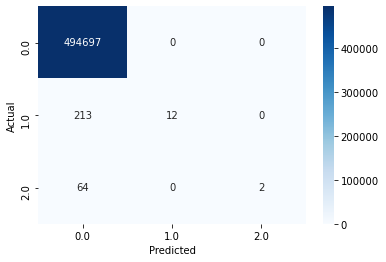

In [136]:
#plt.figure(figsize=(12, 9))

data = {'y_Actual': y_valid.ravel(), 'y_Predicted': predicted_target.ravel()}
df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
#confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'], margins = True)
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')
plt.show()

In [54]:
#confusion_matrix(y_valid, predicted_target)
#print(classification_report(y_valid, predicted_target, target_names=['0', '1', '2']))

In [ ]:
#тоже через вероятности классов
predicted_target = clf.predict_proba(X_valid)
df_predictions = pd.DataFrame(predicted_target, index=X_valid.index, columns=[0, 1, 2])
predicted_target = df_predictions.apply(lambda x: x.argmax(), axis=1)
#predicted_target = df_predictions.idxmax(axis=1)
df_predictions.head()

### Прогноз и сохранение результата

In [137]:
%%time
# предсказание значений переменной target
test['target'] =  clf.predict(test[columns]).astype(int)
prediction = test[['datetime','road_id','road_km','target']]
prediction = remove_zero(prediction)
#prediction['target'] = 1
prediction.to_csv('submission/prediction10.csv', index=False)
compression_opts = dict(method='zip', archive_name='prediction7.csv')
prediction.to_csv('submission/prediction10.zip', index=False, compression=compression_opts)
prediction.head()

CPU times: user 1min 26s, sys: 155 ms, total: 1min 26s
Wall time: 23.6 s


,datetime,road_id,road_km,target
1435832,2019-01-26 12:00:00,14,16,2
2073873,2020-07-21 09:00:00,9,22,1
2073874,2020-07-21 09:00:00,9,22,1
2073875,2020-07-21 09:00:00,9,22,1
2073876,2020-07-21 09:00:00,9,22,1


In [138]:
clf.save_model('cat_clf.cbm')
#clf.load_model('cat_clf.cbm')

 Важность фич

Text(0.5, 0, 'Importance')

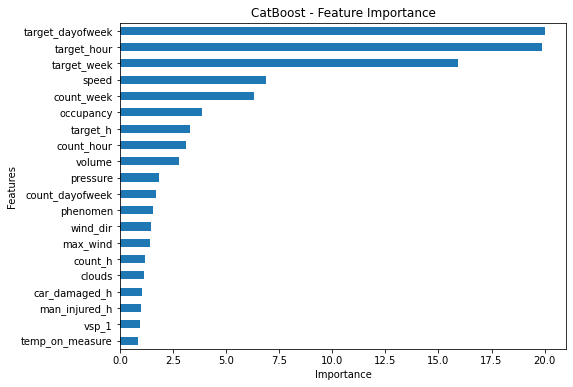

In [80]:
fea_imp = pd.DataFrame({'imp': clf.feature_importances_, 'col': X_train.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-20:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(8, 6), legend=None)
plt.title('CatBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance')